In [8]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from mil.data.mnist import Bag, OneHotMNISTBags
from mil.utils import device
from mil.models import MILModel
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head
from mil.models.attention import WeightedAverageAttention, MultiHeadAttention


# One hot MNIST bags

This notebook trains models on the one-hot MNIST bags dataset, where the dataset yields 10-dimensional one-hot encoded feature vectors directly (i.e. we are not yet working with MNIST digits).
The goal of this notebook is to try and get various models to overfit on the one-hot versions of *mnist-bags* and *multi-mnist-bags*.

The following cell defines two variables, `TARGET_NUMBERS` and `MODEL` which can be used to run different dataset/model configurations.

`TARGET_NUMBERS`:
- `9` corresponds to the *mnist-bags* dataset
- `(9, 7)` corresponds to the *multi-mnist-bags* dataset

`MODELS`:
- `"max_pool"`: simple baseline that uses max pooling. Works neither dataset.
- `"max_pool"`: simple baseline that uses mean pooling. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"weighted_average_attention"`: uses attention mechanism from "Attention Based Deep Multiple Instance Learning" paper which can only "focus" on one target number at a time. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"self_attention"`: uses a transformer layer (self attention) followed by mean pooling. Works for both datasets.


Try changing `TARGET_NUMBERS` and `MODELS` below and rerunning the notebook.

In [9]:
TARGET_NUMBERS = 9
TARGET_NUMBERS = (9, 7)

MODEL = "mean_pool"
MODEL = "max_pool"
MODEL = "weighted_average_attention"
MODEL = "self_attention"

In [10]:
def make_data_loader(train: bool = True):
    """Utility function to create a data loader for the dataset."""
    ds = OneHotMNISTBags(target_numbers=TARGET_NUMBERS, # target number
                        min_instances_per_target=1, # 1 instance of a "9" suffices to label a bag as positive
                        num_digits=10, # sample from all 10 MNIST digits
                        mean_bag_size=10, # mean bag length
                        var_bag_size=2, # variance of bag length
                        num_bags=250, # number of bags
                        seed=1,
                        train=train)
    loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=train, collate_fn=lambda x: x[0])
    return loader

## Define the model

This is a super simple baseline model for `OneHotBags`. The three parts of the MIL model are:
1. **feature extractor**: no feature extractor, as the features are already the one-hot encoded digits (feature vectors are 10-dimensional)
2. **max pooling**: simply retrieve maximum for each of the 10 dimensions in the feature vector
3. **classifier**: linear layer from 10 to one unit followed by sigmoid


In [11]:
class OneHotFeatureExtractor(nn.Module):
    def forward(self, bag: Bag):
        # In the case of OneHotBags, the instances are already the features.
        return bag.instances

class Aggregate(nn.Module):
    """Simple pooling layer for mean/max pooling."""
    def __init__(self, pool: str = "mean", dim: int = 0):
        super().__init__()
        self.pool = pool
        self.dim = dim

    def forward(self, features):
        pool = getattr(torch, self.pool)
        result = pool(features, dim=self.dim)
        if self.pool == "max":
            result = result.values
        return result

class Pooler(nn.Module):
    def __init__(self, pooling_layer: nn.Module):
        super().__init__()
        self.pooling_layer = pooling_layer
    
    def forward(self, bag, features):
        return self.pooling_layer(features)

class Classifier(nn.Sequential):
    def __init__(self, feature_size: int):
        super().__init__(
            nn.Linear(feature_size, 1),
            nn.Sigmoid()
        )

attention_layer = None

# Define model
if MODEL == "mean_pool":
    model = MILModel(feature_extractor=OneHotFeatureExtractor(),
                     pooler=Pooler(Aggregate("mean")),
                     classifier=Classifier(feature_size=10))
elif MODEL == "max_pool":
    model = MILModel(feature_extractor=OneHotFeatureExtractor(),
                     pooler=Pooler(Aggregate("max")),
                     classifier=Classifier(feature_size=10))
elif MODEL == "weighted_average_attention":
    attention_layer = WeightedAverageAttention(feature_size=10, hidden_dim=10)
    model = MILModel(feature_extractor=OneHotFeatureExtractor(),
                    pooler=Pooler(attention_layer),
                    classifier=Classifier(feature_size=10))
elif MODEL == "self_attention":
    attention_layer = MultiHeadAttention(feature_size=10, hidden_dim=10)
    att = nn.Sequential(attention_layer, Aggregate("mean"))
    model = MILModel(feature_extractor=OneHotFeatureExtractor(),
                    pooler=Pooler(att),
                    classifier=Classifier(feature_size=10))
else:
    raise ValueError(f"Unknown model {MODEL}")


## Define loss function and optimizer

We use binary cross-entropy loss.

In [12]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

## Train

In [13]:
loader = make_data_loader(train=True)

model.train()
for epoch in range(30):
    total_loss = 0.
    total_error = 0.
    for bag in loader:
        bag = device(bag)
        y = bag.bag_label

        optimizer.zero_grad()

        # Calculate loss and metrics
        y_pred = model(bag).squeeze(0)
        loss = loss_function(y_pred, y)

        error = 1. - ((y_pred > .5).float() == y).cpu().detach().float()
        total_error += error
        
        # Backward pass
        loss.backward()

        total_loss += loss.detach().cpu()
        # Step
        optimizer.step()

    print(
        f"Epoch: {epoch}, loss: {total_loss/len(loader):.4f}, error: {total_error/len(loader):.4f}")

Epoch: 0, loss: 0.6866, error: 0.4160
Epoch: 1, loss: 0.6685, error: 0.2760
Epoch: 2, loss: 0.6328, error: 0.2000
Epoch: 3, loss: 0.5693, error: 0.1760
Epoch: 4, loss: 0.4934, error: 0.1480
Epoch: 5, loss: 0.4298, error: 0.1520
Epoch: 6, loss: 0.3874, error: 0.1400
Epoch: 7, loss: 0.3567, error: 0.1400
Epoch: 8, loss: 0.3342, error: 0.1200
Epoch: 9, loss: 0.3147, error: 0.1120
Epoch: 10, loss: 0.2952, error: 0.1040
Epoch: 11, loss: 0.2740, error: 0.0960
Epoch: 12, loss: 0.2524, error: 0.0760
Epoch: 13, loss: 0.2309, error: 0.0800
Epoch: 14, loss: 0.2065, error: 0.0760
Epoch: 15, loss: 0.1833, error: 0.0560
Epoch: 16, loss: 0.1602, error: 0.0440
Epoch: 17, loss: 0.1384, error: 0.0360
Epoch: 18, loss: 0.1194, error: 0.0280
Epoch: 19, loss: 0.1019, error: 0.0240
Epoch: 20, loss: 0.0877, error: 0.0160
Epoch: 21, loss: 0.0748, error: 0.0120
Epoch: 22, loss: 0.0644, error: 0.0160
Epoch: 23, loss: 0.0555, error: 0.0120
Epoch: 24, loss: 0.0479, error: 0.0080
Epoch: 25, loss: 0.0414, error: 0.0

## Test

Test loss: 0.0198, error: 0.0000


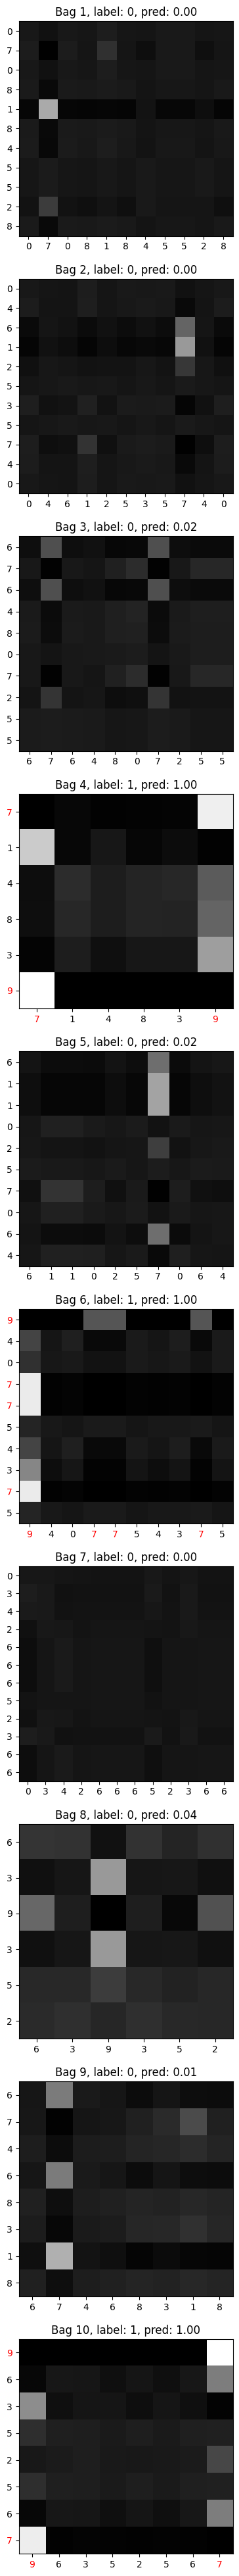

In [14]:
loader = make_data_loader(train=False)
model.eval()

total_loss = 0.
total_error = 0.


if isinstance(attention_layer, MultiHeadAttention):
    plt.figure(figsize=(5, 50))


with torch.no_grad():
    for i, bag in enumerate(loader):
        bag = device(bag)
        y = bag.bag_label.float()

        # Calculate loss and metrics
        y_pred = model(bag).squeeze(0)
        loss = loss_function(y_pred, y)

        error = 1. - ((y_pred > .5).float() == y).cpu().detach().float()
        total_error += error
        total_loss += loss.detach().cpu()

        if i < 10:  # Print bag labels and instance labels for first 5 bags
            if isinstance(attention_layer, WeightedAverageAttention):
                print_one_hot_bag_with_attention(bag, attention_layer.A, y_pred>.5)
                print()
            elif isinstance(attention_layer, MultiHeadAttention):
                plt.subplot(10, 1, i+1)
                plot_attention_head(bag, attention_layer.A[0])
                plt.title(f"Bag {i+1}, label: {y.item():.0f}, pred: {y_pred.item():.2f}")
            else:
                print_one_hot_bag(bag, y_pred>.5)

print(
    f"Test loss: {total_loss/len(loader):.4f}, error: {total_error/len(loader):.4f}")
